In [1]:
# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor
from preprocessing import *

# external libs
import pandas as pd
import geopandas as gpd
from shapely import wkt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

/usr/local/Caskroom/miniconda/base/envs/urban-form-ml/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
%load_ext autoreload
%autoreload 2

## Data

In [4]:
path_data_france = os.path.join('..', 'data', 'france-cities-200.csv')
data_france = pd.read_csv(path_data_france)

In [6]:
len(data_france.dropna(subset=[dataset.AGE_ATTRIBUTE])) / len(data_france)

0.4109978305234059

In [8]:
import glob

geom_files = glob.glob('../data/geographics/*/*_geom.csv') + glob.glob('../data/geographics/*_geom.csv')
data_geom = pd.concat((pd.read_csv(f) for f in geom_files), ignore_index=True)


## Data Preparation

In [9]:
data_geom_w_age = pd.concat([data_geom.set_index('id'), data_france[['id', dataset.AGE_ATTRIBUTE]].set_index('id')], axis=1, join="inner").reset_index()
data_geom_w_age = data_geom_w_age.dropna(subset=[dataset.AGE_ATTRIBUTE])

data_france_w_geo = data_france[data_france['id'].isin(data_geom['id'])]

2022-01-18 14:16:26,074 | INFO : Dataset length: 91273
2022-01-18 14:16:26,191 | INFO : Test dataset length: 18255
2022-01-18 14:16:26,192 | INFO : Training dataset length: 73018
2022-01-18 14:16:26,193 | INFO : Standard deviation of test set: 60.453445572902154
2022-01-18 14:16:26,411 | INFO : Test dataset length after preprocessing: 14573
2022-01-18 14:16:26,412 | INFO : Training dataset length after preprocessing: 57992
2022-01-18 14:16:26,413 | INFO : Standard deviation of test set after preprocessing: 28.80684261501316


MAE: 14.531508966978745 y
RMSE: 20.011755470553066 y
R2: 0.5173760636163129


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


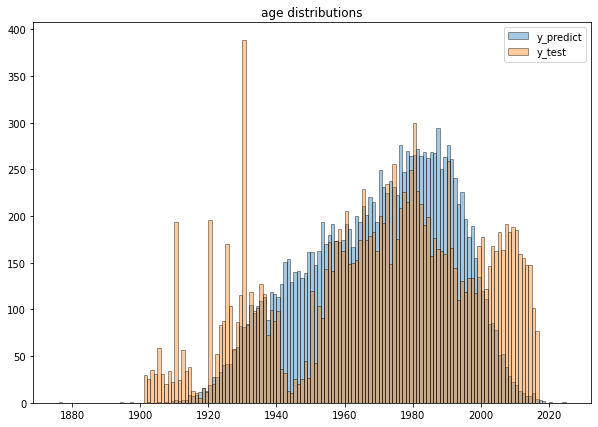

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

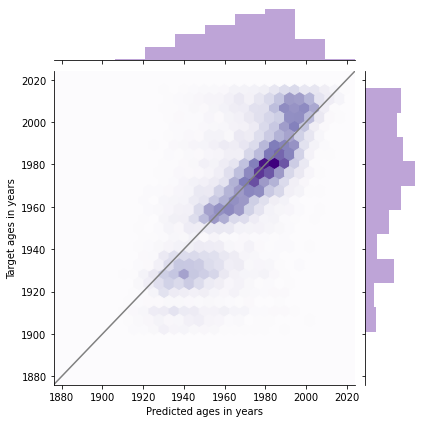

invalid value encountered in true_divide


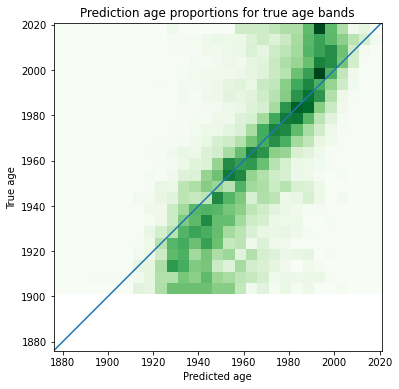

In [11]:
%matplotlib inline

predictor_80_20 = AgePredictor(
    model=XGBRegressor(),
    df=data_france_w_geo,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers]
)
predictor_80_20.evaluate_regression()

2022-01-18 14:19:45,720 | INFO : Dataset length: 91273
2022-01-18 14:19:45,762 | INFO : Test dataset length: 6970
2022-01-18 14:19:45,763 | INFO : Training dataset length: 84303
2022-01-18 14:19:45,764 | INFO : Standard deviation of test set: 59.61299007131891
2022-01-18 14:19:45,929 | INFO : Test dataset length after preprocessing: 5899
2022-01-18 14:19:45,930 | INFO : Training dataset length after preprocessing: 66666
2022-01-18 14:19:45,931 | INFO : Standard deviation of test set after preprocessing: 23.218494819309505


MAE: 19.092401370332894 y
RMSE: 24.02816430436355 y
R2: -0.07114111356902209


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


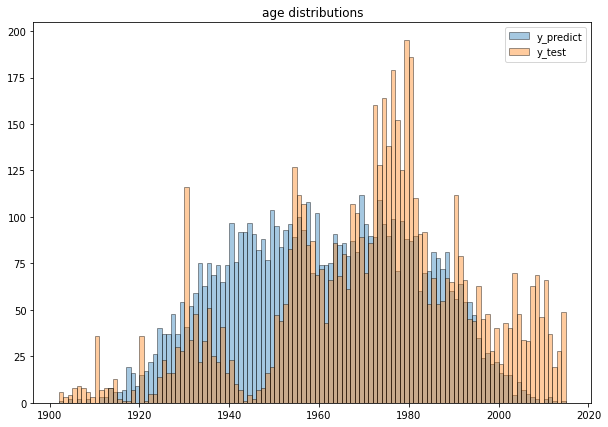

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

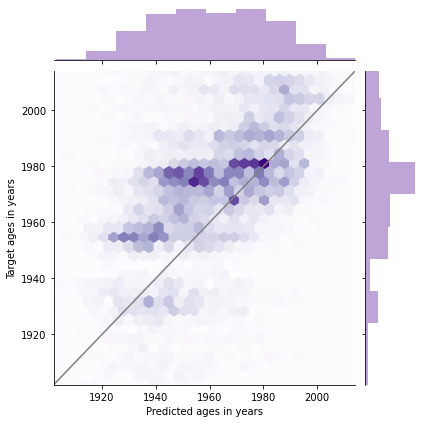

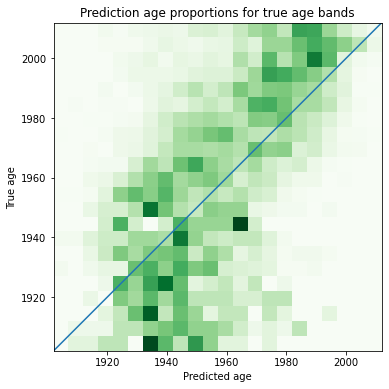

In [17]:
%matplotlib inline

predictor_city_split = AgePredictor(
    model=XGBRegressor(),
    df=data_france_w_geo,
    test_training_split=split_by_city,
    preprocessing_stages=[remove_outliers]
)
predictor_city_split.evaluate_regression()

## Visualizations

In [20]:
%matplotlib qt

### Age

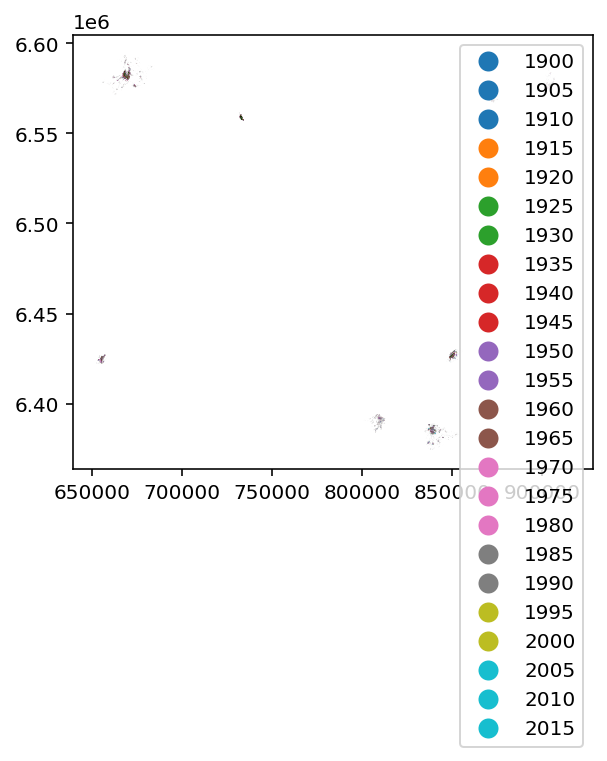

In [14]:
visualizations.plot_age_on_map(data_france, data_geom)

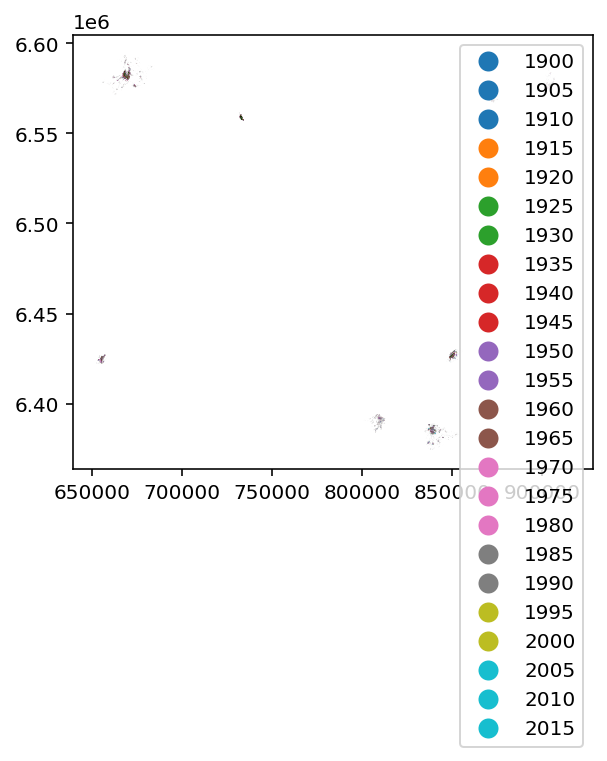

In [ ]:
visualizations.plot_age_on_map(data_france, data_geom)

### Prediction error


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


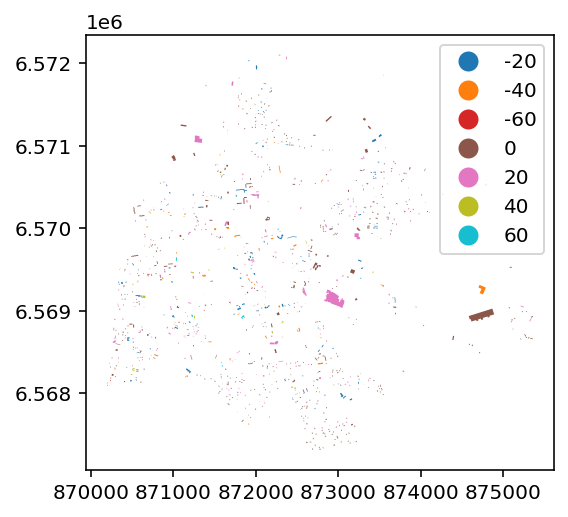

In [21]:
# only 20% of all city buildings are plotted (makes it hard to understand impact of neighborhood structure on prediction error)
data_france_bourgenbresse = data_france_w_geo[data_france_w_geo['city'] == 'Bourg-en-Bresse']
data_geo_bourgenbresse = data_geom[data_geom['id'].isin(data_france_bourgenbresse['id'])]

prediction_error = predictor_80_20.individual_prediction_error()
visualizations.plot_prediction_error_on_map(prediction_error, data_geo_bourgenbresse)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


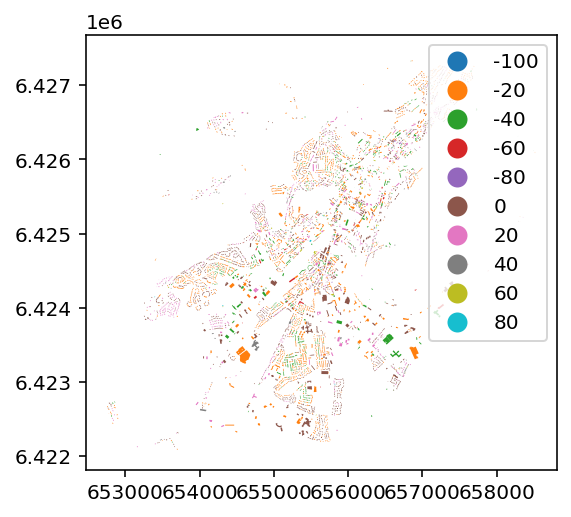

In [19]:
# all buildings for a single city are plotted (higher prediction error though compared to 80/20 split)
prediction_error = predictor_city_split.individual_prediction_error()
visualizations.plot_prediction_error_on_map(prediction_error, data_geom)

### Impact of geographical heterogenity on prediction error

In [283]:
data_france_w_geo_column = pd.concat([data_france.set_index('id'), data_geom.set_index('id')], axis=1, join="inner").reset_index()

gdf = gpd.GeoDataFrame(data_france_w_geo_column,
                    geometry=data_france_w_geo_column['geometry'].apply(wkt.loads),
                    crs=7794)

In [294]:
# utils.get_indexes_right_round_buffer(gdf.copy(), gdf.copy(), 100)
building_gdf_for_join = gpd.GeoDataFrame(geometry=gdf.geometry)

# # Create a gdf with a buffer per object of interest as a single geometry column
buffer = gdf.geometry.centroid.buffer(100).values
gpd.GeoDataFrame(geometry=buffer).info()
# joined_gdf = gpd.sjoin(buffer_gdf, building_gdf_for_join, how="left", op="intersects")


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 180913 entries, 0 to 180912
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   geometry  180913 non-null  geometry
dtypes: geometry(1)
memory usage: 1.4 MB


In [295]:
gpd.GeoDataFrame(geometry=gdf.geometry).info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 180913 entries, 0 to 180912
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   geometry  180913 non-null  geometry
dtypes: geometry(1)
memory usage: 1.4 MB
